1.setting up and installing libraries.

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_md

import pandas as pd
import spacy
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 56.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


2.Loading spacy model.

In [ ]:
nlp = spacy.load("en_core_web_md")

3.We begin by loading two CSV files: one containing fake news articles and the other containing real news. We add labels to each and combine them into a single dataset for processing.


In [ ]:
fake_df = pd.read_csv("Fake.csv")
truth_df = pd.read_csv("True.csv")

fake_df["label"] = 0
truth_df["label"] = 1

df = pd.concat([fake_df, truth_df]).reset_index(drop=True)

# Optional: Reducing data size for faster processing
df = df.sample(n=10000, random_state=42)  # we can increase n later

4.We clean and prepare the text data by removing punctuation, converting to lowercase, removing stopwords, and lemmatizing the words to their base form.


In [ ]:
def clean_text(text):
    text = re.sub(r"[^\w\s]", "", str(text).lower())
    return text

df["text"] = df["text"].apply(clean_text)

5.We use spaCy to convert each document into a fixed-length vector by averaging word embeddings. These document-level vectors are used as input features for our classifier.


In [ ]:
def get_vector(text):
    doc = nlp(text)
    return doc.vector

tqdm.pandas()
df["vector"] = df["text"].progress_apply(get_vector)

100%|██████████| 10000/10000 [13:09<00:00, 12.67it/s]


6.We separate the input features (X) and output labels (y). The vectors are stacked into a matrix, and labels are extracted as a 1D array.

In [ ]:
import numpy as np

X = np.vstack(df["vector"].values)
y = df["label"].values


7.We split the data into training and testing sets (80/20 split), and train a logistic regression model on the training data.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

8.We evaluate the classifier using precision, recall, and F1-score metrics to assess how well the model distinguishes between fake and real news.


In [ ]:
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

              precision    recall  f1-score   support

        Fake       0.96      0.93      0.94      1081
        Real       0.92      0.95      0.93       919

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



9. we are trying improve the model’s performance by choosing the best threshold (instead of using the default 0.5) based on the F1-score or any other metric.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


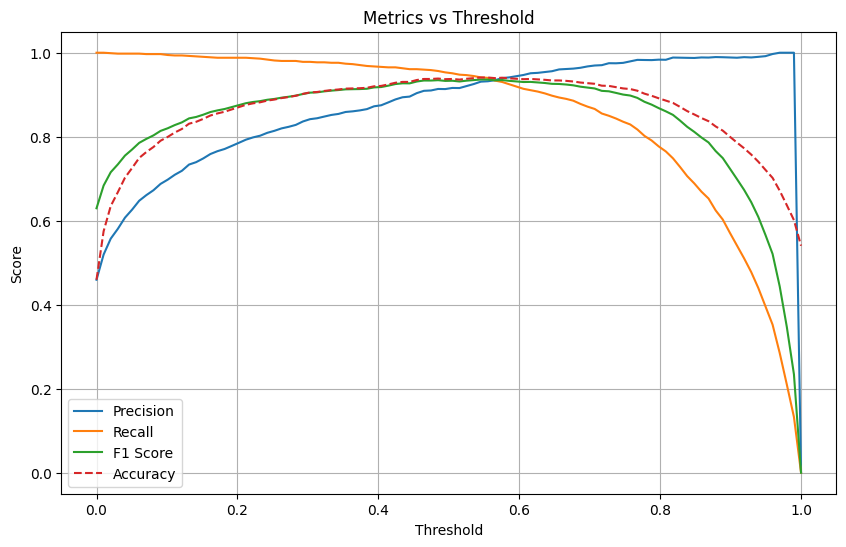

Best Threshold: 0.55
Precision: 0.931
Recall:    0.941
F1 Score:  0.936
Accuracy:  0.941

Final Classification Report with Best Threshold:
              precision    recall  f1-score   support

        Fake       0.95      0.94      0.95      1081
        Real       0.93      0.94      0.94       919

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report

# Get predicted probabilities for the positive class (label 1 - Real)
y_proba = clf.predict_proba(X_test)[:, 1]

# Try different thresholds between 0 and 1
thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1s, accuracies = [], [], [], []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary')
    acc = accuracy_score(y_test, y_pred_thresh)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    accuracies.append(acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, accuracies, label='Accuracy', linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Show best F1 threshold and classification report
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Precision: {precisions[best_idx]:.3f}")
print(f"Recall:    {recalls[best_idx]:.3f}")
print(f"F1 Score:  {f1s[best_idx]:.3f}")
print(f"Accuracy:  {accuracies[best_idx]:.3f}")

# Apply best threshold to get final predictions
y_final = (y_proba >= best_threshold).astype(int)

# Final Evaluation
print("\nFinal Classification Report with Best Threshold:")
print(classification_report(y_test, y_final, target_names=["Fake", "Real"]))
